In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import plotly as py
import json
import geopandas as gpd
import plotly.express as px
import plotly.io as pio

In [2]:
bd_district = json.load(open('/home/shakibibneshameempolock/Documents/with Saikat Vai/BD_MAP_JSON/bangladesh_districts.geojson', 'r'))

In [3]:
#establishing the connection
conn = psycopg2.connect(
    database="******", 
    user='*****', 
    password='******', 
    host='*******', 
    port= '***********'
)

In [4]:
cursor = conn.cursor()
query= f"""
            select  d.district_name, sum(la.disbursed_amount) as disbursed_amount  
            from loan_account la
                inner join physical_office_info poi on la.office_info_id = poi.id
                inner join geo_info gi on poi.id = gi.office_id
                inner join district d on d.id = gi.district_id
            where la.disbursement_date between '2021-01-01' and '2021-12-31'
                group by d.district_name
                order by disbursed_amount desc
        """

cursor.execute(query)

data = cursor.fetchall()

df = pd.DataFrame(data)
df.set_axis(["district_name", "disbursed_amount"],axis=1,inplace=True)
df.head()


,district_name,disbursed_amount
0,Cumilla,3.296199e+10
1,Dhaka,2.638223e+10
2,Brahmanbaria,1.488756e+10
3,Chattogram,1.426116e+10
4,Gazipur,1.292352e+10


In [5]:
df['disbursed_amount'] = df['disbursed_amount'].astype('int64')
df['disbursed_amount_scale'] = np.log10(df['disbursed_amount'])

#df['disbursed_amount'] = np.round(df['disbursed_amount']/1000000000, 2)

In [7]:
df.head()

,district_name,disbursed_amount,disbursed_amount_scale
0,Cumilla,32961989728,10.518013
1,Dhaka,26382234876,10.421312
2,Brahmanbaria,14887559091,10.172823
3,Chattogram,14261155193,10.154155
4,Gazipur,12923523220,10.111381


In [8]:
dist_id_map = {}
for feature in bd_district['features']:
    feature['id'] = feature['properties']['district']
    dist_id_map[feature['properties']['district']] = feature['id']
    

In [9]:
df['id'] = df['district_name'].apply(lambda x : dist_id_map[x])

In [10]:
df.head()

,district_name,disbursed_amount,disbursed_amount_scale,id
0,Cumilla,32961989728,10.518013,Cumilla
1,Dhaka,26382234876,10.421312,Dhaka
2,Brahmanbaria,14887559091,10.172823,Brahmanbaria
3,Chattogram,14261155193,10.154155,Chattogram
4,Gazipur,12923523220,10.111381,Gazipur


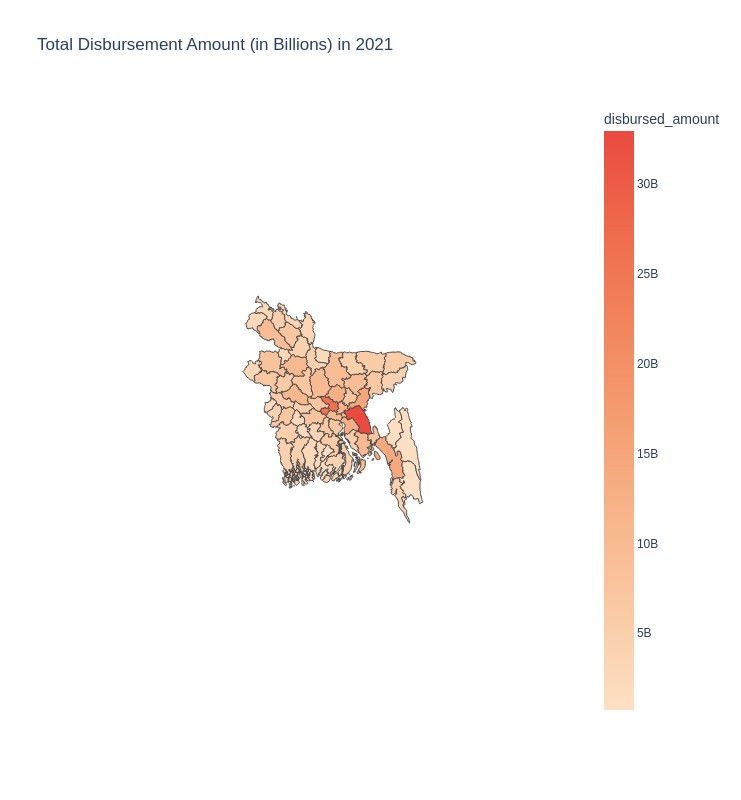

In [20]:
fig = px.choropleth(df, 
                    locations = 'id', 
                    geojson = bd_district, 
                    #scope = 'asia',
                    color="disbursed_amount",
                    title = 'Total Disbursement Amount (in Billions) in 2021',
                    color_continuous_scale = 'peach',
                    width = 1000,
                    height = 800
                   )
#'district_name', 'disbursed_amount', 'disbursed_amount_scale', 'id'
fig.update_geos(fitbounds="locations", visible=False)
fig.show()